In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pyreadr

import timeit

from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from xgboost import plot_tree

In [2]:
stjamesdf = pd.read_csv('../../data/stjames.csv').drop('Unnamed: 0', axis=1)
stjamesdf = stjamesdf[[ 'x', 'y', 'Habitat', 'DEM', 'sDEM', 'hDEM', 'DSM', 'CHM', 'Aspect', 'Slope',
       'Curvature', 'PlanCurv', 'ProfileCurv', 'NDVI', 'NDRE', 'NDWI', 'Wetland']]

In [3]:
df = pd.DataFrame()

for filename in os.scandir('../../Data'):
    if filename.is_file():
        p = filename.path
        if(p != '../../Data\StJames.csv'):
            df_temp = pd.read_csv(p)
            df.reset_index(drop=True, inplace=True)
            df_temp.reset_index(drop=True, inplace=True)
            df = pd.concat([df, df_temp])

df=df.drop(['Unnamed: 0'], axis=1)

In [4]:
print(df["Wetland"].value_counts())
print(stjamesdf["Wetland"].value_counts())

1    549
0    379
Name: Wetland, dtype: int64
1    80
0    28
Name: Wetland, dtype: int64


In [5]:
X_train = df.drop(['x', 'y', 'Habitat', 'Wetland'], axis=1)
y_train = df.Wetland

X_test = stjamesdf.drop(['x', 'y', 'Habitat', 'Wetland'], axis=1)
y_test = stjamesdf.Wetland

[[26  2]
 [42 38]]
              precision    recall  f1-score   support

           0     0.3824    0.9286    0.5417        28
           1     0.9500    0.4750    0.6333        80

    accuracy                         0.5926       108
   macro avg     0.6662    0.7018    0.5875       108
weighted avg     0.8028    0.5926    0.6096       108

0.3753780999999998


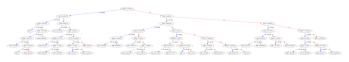

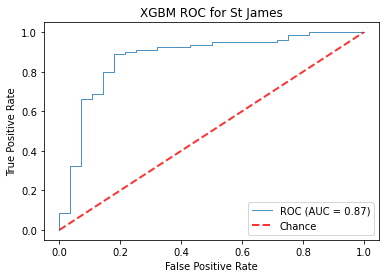

In [6]:
start_time = timeit.default_timer()

model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=69)

model.fit(X_train, y_train)
pred_values = model.predict(X_test)

elapsed = timeit.default_timer() - start_time

tree = plot_tree(model, orientation='vertical')

feature_importance = model.feature_importances_

fig, ax = plt.subplots()
viz = plot_roc_curve(model, X_test, y_test, name='ROC', alpha=0.8, lw=1, ax = ax)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="XGBM ROC for St James")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
ax.legend(loc="lower right")

Truth = y_test.values.reshape(y_test.shape)
Output = pred_values

feature_importances = pd.DataFrame()
feature_importance = model.feature_importances_
rel_imp = pd.DataFrame(feature_importance, index=X_train.columns, columns=[0])
feature_importances = pd.concat([feature_importances, rel_imp], axis=1)[0]

print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output, digits=4))
print(elapsed)

Text(0.5, 1.0, 'Variable Importance for StJames')

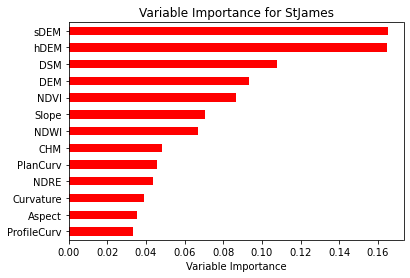

In [9]:
fig = feature_importances.sort_values()[-24:].T.plot(kind = 'barh', 
               color = 'r')
fig.set_xlabel("Variable Importance")
fig.set_title("Variable Importance for StJames")

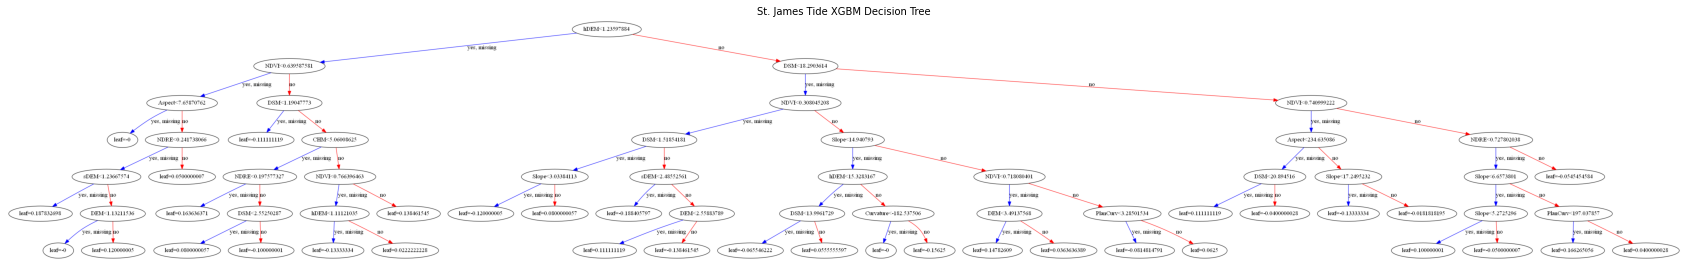

In [8]:
_, ax = plt.subplots(figsize=(30,10)) # Resize figure
plot_tree(model, filled=True, ax=ax, orientation='vertical')
plt.title("St. James Tide XGBM Decision Tree", fontsize=10)
plt.savefig('StJamesDT.png', dpi=1000)

Text(0.5, 1.0, 'StJames sDEM')

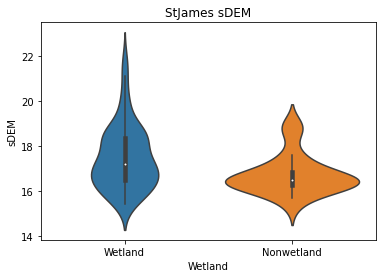

In [31]:
plotdf = stjamesdf.copy()
plotdf.loc[plotdf["Wetland"]==0, "Wetland"] = "Nonwetland"
plotdf.loc[plotdf["Wetland"]==1, "Wetland"] = "Wetland"
p = sns.violinplot(data=plotdf, x="Wetland", y="sDEM")
p.set_title("StJames sDEM")

In [25]:
result = pyreadr.read_r('../../../StJames/StJames_all.rds')
df_all = result[None]

In [26]:
X_all = df_all.drop(['x', 'y', 'Habitat'], axis=1)
coords_all = df_all[['x', 'y']]
Coords = coords_all
Output = []

In [27]:
pred_values = model.predict(X_all)
Output.extend(pred_values)

In [28]:
test_df = pd.concat([Coords, pd.DataFrame(Output, columns=["Output"])], axis=1)
test_df['Output'].value_counts()

0    5335705
1    2684101
Name: Output, dtype: int64

In [29]:
test_df.to_csv("../Comparison Data/StJamesAll.csv", index=False)